<a href="https://colab.research.google.com/github/fajrunwm/gisml/blob/main/Agriculture_Augmentation_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agriculture Augmentation

# Phase 1: Satellite Data Transformation

## Data Preparation

In [1]:
# Install required libraries
!pip install pystac_client planetary_computer rasterio earthpy matplotlib -q

In [2]:
# Environment setup
from pystac.extensions.eo import EOExtension as eo

import pystac_client
import planetary_computer as pc
import rasterio

from rasterio import features, windows, warp
from rasterio.features import bounds
from rasterio.plot import show
from rasterio.warp import transform_bounds

import earthpy.plot as ep
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)

In [3]:
# Data access
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=pc.sign_inplace,
)

print("Connected to MPC Catalog")

Connected to MPC Catalog


In [4]:
"""
# Search for Dataset Collection
for collection in sorted(catalog.get_all_collections(), key=lambda c: c.id):
  print(collection.id)
"""

'\n# Search for Dataset Collection\nfor collection in sorted(catalog.get_all_collections(), key=lambda c: c.id):\n  print(collection.id)\n'

In [5]:
# Define Area of Interest (AOI)
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [101.004689, 0.854101],  # Top left
            [101.172633, 0.854101],  # Top right
            [101.172633, 0.724275],  # Bottom right
            [101.004689, 0.724275],  # Bottom left
            [101.004689, 0.854101],  # Closing the polygon
        ]
    ],
}

In [6]:
# Define Date Range
date = "2023-01-01/2024-12-31"

In [7]:
# Define Could Cover tolerance
cc = 25

In [8]:
# Search for Sentinel-2 data with cloud cover filter
search = catalog.search(
    collections=["sentinel-2-l2a"],  # Dataset
    intersects=aoi,    # Area of Interest
    datetime=date,  # Date range
    query={"eo:cloud_cover": {"lt": cc}},  # Cloud cover filter (<10%)
)

In [9]:
# Check how many items were found
items = list(search.items())
print(f"Found {len(items)} items with cloud cover < {cc}%:")
for i in items:
    print(f"<> {i.datetime.date()} with cloud cover {eo.ext(i).cloud_cover}%")

Found 7 items with cloud cover < 25%:
<> 2024-09-24 with cloud cover 19.776554%
<> 2024-07-11 with cloud cover 24.700031%
<> 2024-07-11 with cloud cover 12.136421%
<> 2023-08-06 with cloud cover 21.42489%
<> 2023-06-17 with cloud cover 12.931514%
<> 2023-04-13 with cloud cover 24.83363%
<> 2023-04-13 with cloud cover 2.956269%


In [10]:
# Choose the least cloudy item
least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
    f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover."
)

Choosing S2A_MSIL2A_20230413T032511_R018_T47NQA_20230413T101752 from 2023-04-13 with 2.956269% cloud cover.


In [11]:
# Get the first item
#item = next(search.get_items())

# Sign the item's assets for direct access
signed_item = pc.sign(least_cloudy_item)

# Collect band information
band_info = []

for asset_key, asset in signed_item.assets.items():
    bands = asset.extra_fields.get('eo:bands', [])
    for band in bands:
        band_info.append({
            "Asset Title": asset.title,
            #"Asset": asset_key,
            "Band Name": band.get("name", "N/A"),
            "Common Name": band.get("common_name", "N/A"),
            "Resolution (m)": asset.extra_fields.get("gsd", "N/A"),  # Extract spatial resolution
            "Center Wavelength (µm)": band.get("center_wavelength", "N/A"),
            "Full Width Half Max (µm)": band.get("full_width_half_max", "N/A"),
        })

# Convert to a DataFrame
band_df = pd.DataFrame(band_info)

# Display the DataFrame
band_df

Asset Title Band Name Common Name  \
0          Band 1 - Coastal aerosol - 60m       B01     coastal   
1                     Band 2 - Blue - 10m       B02        blue   
2                    Band 3 - Green - 10m       B03       green   
3                      Band 4 - Red - 10m       B04         red   
4    Band 5 - Vegetation red edge 1 - 20m       B05     rededge   
5    Band 6 - Vegetation red edge 2 - 20m       B06     rededge   
6    Band 7 - Vegetation red edge 3 - 20m       B07     rededge   
7                      Band 8 - NIR - 10m       B08         nir   
8              Band 9 - Water vapor - 60m       B09         N/A   
9              Band 11 - SWIR (1.6) - 20m       B11      swir16   
10             Band 12 - SWIR (2.2) - 20m       B12      swir22   
11  Band 8A - Vegetation red edge 4 - 20m       B8A     rededge   
12                       True color image       B04         red   
13                       True color image       B03       green   
14                       True color image       B02        blue   

    Resolution (m)  Center Wavelength (µm)  Full Width Half Max (µm)  
0             60.0                   0.443                     0.027  
1             10.0                   0.490                     0.098  
2             10.0                   0.560                     0.045  
3             10.0                   0.665                     0.038  
4             20.0                   0.704                     0.019  
5             20.0                   0.740                     0.018  
6             20.0                   0.783                     0.028  
7             10.0                   0.842                     0.145  
8             60.0                   0.945                     0.026  
9             20.0                   1.610                     0.143  
10            20.0                   2.190                     0.242  
11            20.0                   0.865                     0.033  
12            10.0                   0.665                     0.038  
13            10.0                   0.560                     0.045  
14            10.0                   0.490                     0.098

## Image Visualisation

In [12]:
# Define the Sentinel-2 bands to use for the composite
band_names = [
    "B01", # Coastal aerosol
    "B02", # Blue
    "B03", # Green
    "B04", # Red
    "B05", # Vegetation red edge 1
    "B06", # Vegetation red edge 2
    "B07", # Vegetation red edge 3
    "B08", # NIR band
    "B8A", # Water vapor
    "B09", # SWIR (1.6)
    "B11", # SWIR (2.2)
    "B12", # Vegetation red edge 4
]

In [13]:
# Find the matching assets from the signed item
band_assets = {}
for band in band_names:
    asset = next(
        (asset for asset_key, asset in signed_item.assets.items()
         if asset.extra_fields.get("eo:bands", [{}])[0].get("name") == band),
        None,
    )
    if asset:
        band_assets[band] = asset.href

# Ensure we have all the bands
if len(band_assets) != len(band_names):
    missing_bands = set(band_names) - set(band_assets.keys())
    raise ValueError(f"Missing bands: {missing_bands}")

### Full coverage

In [14]:
# Load the bands
# Assign Red (B04), Green (B03), and Blue (B02) bands
with rasterio.open(band_assets["B04"]) as red_src, \
     rasterio.open(band_assets["B03"]) as green_src, \
     rasterio.open(band_assets["B02"]) as blue_src:

    # Read the data to the palletes
    red = red_src.read(1)  # Red pallete
    green = green_src.read(1)  # Green pallete
    blue = blue_src.read(1)  # Blue pallete

    # Check for consistent shapes
    assert red.shape == green.shape == blue.shape, "Bands must have the same dimensions."

    # Stack bands into an array for visualization
    composite = np.dstack((red, green, blue))

    # Normalize the composite for display (0-255 range)
    #composite_normalized = np.clip((composite / composite.max()) * 255, 0, 255).astype(np.uint8)

    # Apply a scaling factor to enhance brightness
    scale_factor = 5.0  # Adjust this factor to make the image brighter
    composite_normalized = np.clip((composite / composite.max()) * 255 * scale_factor, 0, 255).astype(np.uint8)

    # Optionally apply gamma correction for further enhancement
    gamma = 0.75  # Lower than 1.0 makes the image darker; higher makes it brighter
    composite_normalized = np.clip(255 * ((composite_normalized / 255) ** (1 / gamma)), 0, 255).astype(np.uint8)

    # Get dataset bounds in EPSG:4326 for the grid
    full_bounds = red_src.bounds
    lon_min, lat_min, lon_max, lat_max = warp.transform_bounds(red_src.crs, "epsg:4326", *full_bounds)

    # Transform AOI bounds to the dataset's CRS
    aoi_bounds = features.bounds(aoi)  # AOI in EPSG:4326
    aoi_pixel_bounds = windows.from_bounds(
        *warp.transform_bounds("epsg:4326", red_src.crs, *aoi_bounds),
        transform=red_src.transform
    )

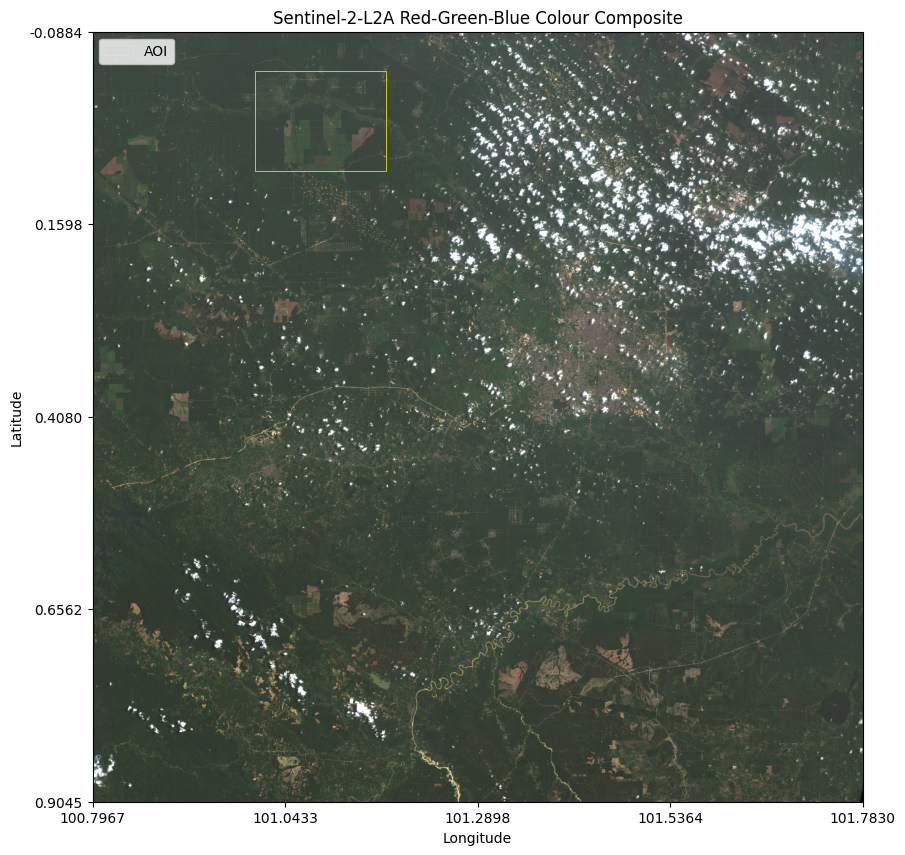

In [15]:
# Plot the RGB composite
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(composite_normalized)
ax.set_xlim(0, composite_normalized.shape[1])
ax.set_ylim(composite_normalized.shape[0], 0)  # Invert y-axis for image coordinates

# Set coordinate grid and labels
lon_ticks = np.linspace(lon_min, lon_max, 5)  # Number of longitude ticks
lat_ticks = np.linspace(lat_min, lat_max, 5)  # Number of latitude ticks

ax.xaxis.set_major_locator(mticker.FixedLocator(
    np.linspace(0, composite_normalized.shape[1], len(lon_ticks))))
ax.xaxis.set_major_formatter(mticker.FixedFormatter([f"{lon:.4f}" for lon in lon_ticks]))

ax.yaxis.set_major_locator(mticker.FixedLocator(
    np.linspace(0, composite_normalized.shape[0], len(lat_ticks))))
ax.yaxis.set_major_formatter(mticker.FixedFormatter([f"{lat:.4f}" for lat in lat_ticks]))

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Add AOI overlay
rect = plt.Rectangle(
    (aoi_pixel_bounds.col_off, aoi_pixel_bounds.row_off),  # Top-left corner in pixels
    aoi_pixel_bounds.width,  # Width in pixels
    aoi_pixel_bounds.height,  # Height in pixels
    edgecolor="yellow",
    facecolor="none",
    linewidth=0.5,
    label="AOI"
)
ax.add_patch(rect)

# Add legend
ax.legend(loc="upper left")
plt.title("Sentinel-2-L2A Red-Green-Blue Colour Composite")
plt.show()

In [16]:
# Print the image size
image_width, image_height, _ = composite_normalized.shape # Use _ to ignore the extra value

print(f"Image size: {image_width} (width) x {image_height} (height)")

Image size: 10980 (width) x 10980 (height)


### AOI Coverage

In [17]:
# Crop the image to the AOI bounds
# Assign Red (B04), Green (B03), and Blue (B02) bands to the Red, Green, and Blue palettes respectively
with rasterio.open(band_assets["B04"]) as red_src, \
     rasterio.open(band_assets["B03"]) as green_src, \
     rasterio.open(band_assets["B02"]) as blue_src:

    # Transform AOI bounds to the dataset's CRS
    aoi_bounds = features.bounds(aoi)  # AOI in EPSG:4326
    aoi_pixel_bounds = windows.from_bounds(
        *warp.transform_bounds("epsg:4326", red_src.crs, *aoi_bounds),
        transform=red_src.transform
    )

    # Read the data within the AOI
    aoi_window = windows.Window(
        col_off=int(aoi_pixel_bounds.col_off),
        row_off=int(aoi_pixel_bounds.row_off),
        width=int(aoi_pixel_bounds.width),
        height=int(aoi_pixel_bounds.height),
    )

    red_aoi = red_src.read(1, window=aoi_window)
    green_aoi = green_src.read(1, window=aoi_window)
    blue_aoi = blue_src.read(1, window=aoi_window)

    # Stack bands into an array for visualization
    composite_aoi = np.dstack((red_aoi, green_aoi, blue_aoi))

    # Normalize the composite for display (0-255 range)
    #composite_aoi_normalized = np.clip((composite_aoi / composite_aoi.max()) * 255, 0, 255).astype(np.uint8)

    # Apply a scaling factor to enhance brightness
    scale_factor = 4.0  # Adjust this factor to make the image brighter
    composite_aoi_normalized = np.clip((composite_aoi / composite_aoi.max()) * 255 * scale_factor, 0, 255).astype(np.uint8)

    # Optionally apply gamma correction for further enhancement
    gamma = 0.5  # Lower than 1.0 makes the image darker; higher makes it brighter
    composite_aoi_normalized = np.clip(255 * ((composite_aoi_normalized / 255) ** (1 / gamma)), 0, 255).astype(np.uint8)

    # Get dataset bounds in EPSG:4326 for the grid (for the cropped AOI)
    aoi_bounds = red_src.window_bounds(aoi_window)
    lon_min, lat_min, lon_max, lat_max = warp.transform_bounds(red_src.crs, "epsg:4326", *aoi_bounds)

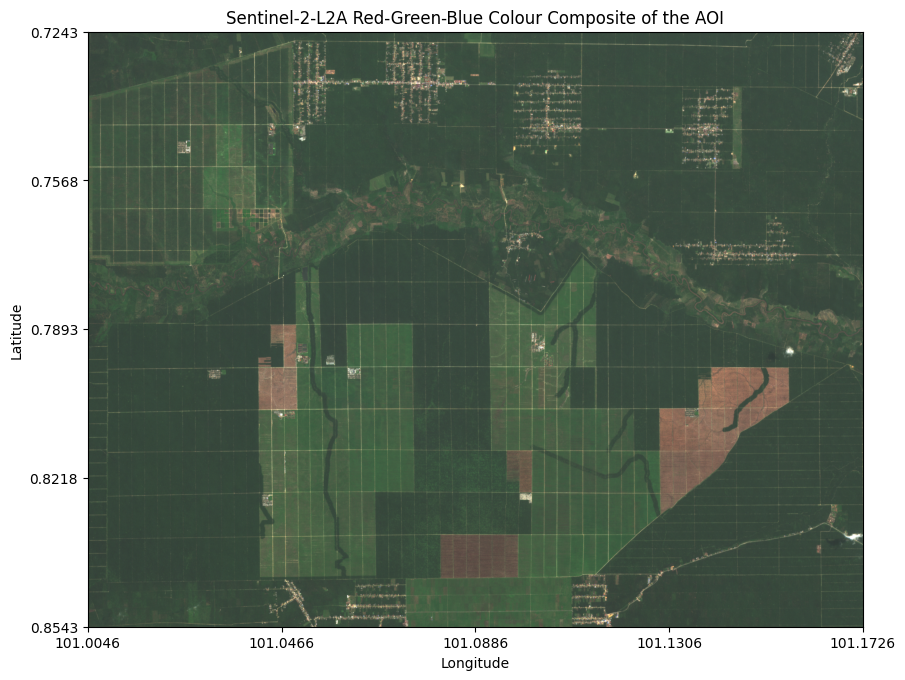

In [18]:
# Plot the cropped AOI image with coordinate grid
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(composite_aoi_normalized)
ax.set_xlim(0, composite_aoi_normalized.shape[1])
ax.set_ylim(composite_aoi_normalized.shape[0], 0)  # Invert y-axis for image coordinates

# Set coordinate grid and labels
lon_ticks = np.linspace(lon_min, lon_max, 5)  # Number of longitude ticks
lat_ticks = np.linspace(lat_min, lat_max, 5)  # Number of latitude ticks

ax.xaxis.set_major_locator(mticker.FixedLocator(
    np.linspace(0, composite_aoi_normalized.shape[1], len(lon_ticks))))
ax.xaxis.set_major_formatter(mticker.FixedFormatter([f"{lon:.4f}" for lon in lon_ticks]))

ax.yaxis.set_major_locator(mticker.FixedLocator(
    np.linspace(0, composite_aoi_normalized.shape[0], len(lat_ticks))))
ax.yaxis.set_major_formatter(mticker.FixedFormatter([f"{lat:.4f}" for lat in lat_ticks]))

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.title("Sentinel-2-L2A Red-Green-Blue Colour Composite of the AOI")
plt.show()

In [19]:
# Print the image size
image_width, image_height, _ = composite_aoi_normalized.shape # Use _ to ignore the extra value

print(f"AOI Image size: {image_width} (width) x {image_height} (height)")

AOI Image size: 1436 (width) x 1870 (height)


## Image Transformation

### Calculate NDVI full coverage

In [20]:
import numpy as np
from rasterio.warp import transform_bounds

# Extract the Red and NIR bands for NDVI calculation
with rasterio.open(band_assets["B08"]) as nir_src, \
     rasterio.open(band_assets["B04"]) as red_src:

    # Read the data for the full image
    nir = nir_src.read(1)
    red = red_src.read(1)

    # Calculate NDVI (NIR - Red) / (NIR + Red), avoiding division by zero
    ndvi = (nir - red) / np.where((nir + red) == 0, np.nan, (nir + red))

    # Ensure values within [-1, 1]
    np.clip(ndvi, -1, 1, out=ndvi)

    # Get full bounds of the raster in its native CRS
    src_bounds = red_src.bounds

    # Transform bounds to EPSG:4326
    lon_min, lat_min, lon_max, lat_max = transform_bounds(red_src.crs, "epsg:4326",
                                                          src_bounds.left, src_bounds.bottom,
                                                          src_bounds.right, src_bounds.top)

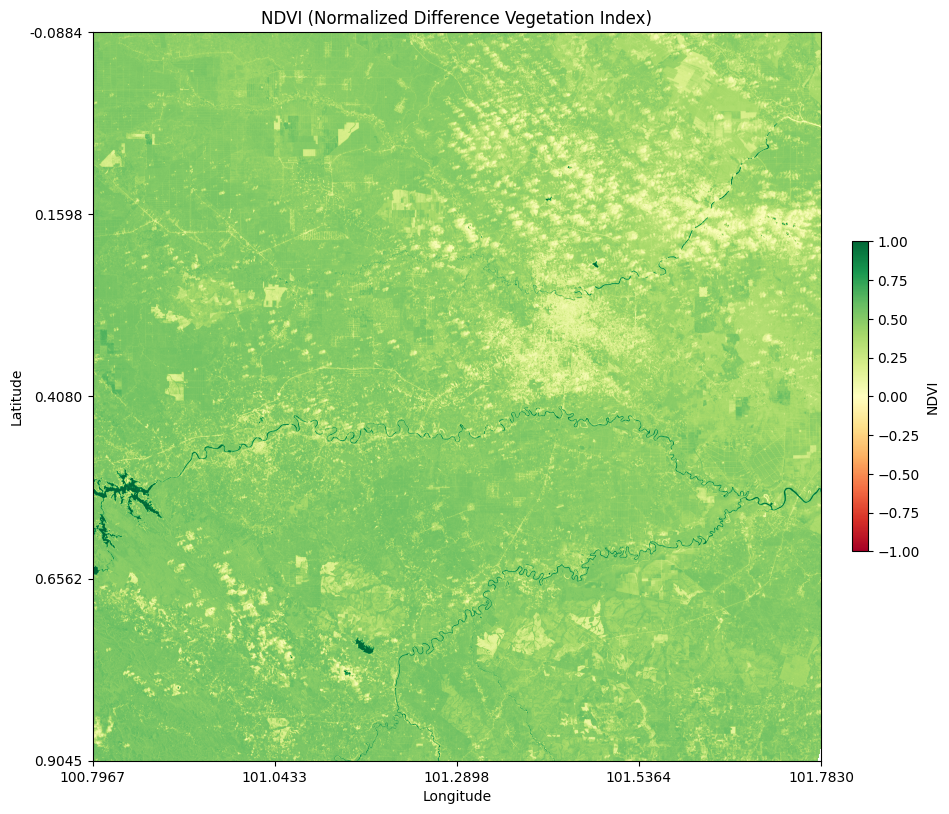

In [21]:
# Plot the NDVI
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the NDVI image with values between -1 and 1
cax = ax.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)  # Set limits for NDVI range (-1 to 1)

ax.set_xlim(0, ndvi.shape[1])
ax.set_ylim(ndvi.shape[0], 0)  # Invert y-axis for image coordinates

# Add a colorbar with dynamic size based on the figure's height
cbar = plt.colorbar(cax, ax=ax, fraction=0.02, pad=0.04)
cbar.set_label('NDVI')

# Set coordinate grid and labels
lon_ticks = np.linspace(lon_min, lon_max, 5)
lat_ticks = np.linspace(lat_min, lat_max, 5)

ax.xaxis.set_major_locator(mticker.FixedLocator(
    np.linspace(0, ndvi.shape[1], len(lon_ticks))))
ax.xaxis.set_major_formatter(mticker.FixedFormatter([f"{lon:.4f}" for lon in lon_ticks]))

ax.yaxis.set_major_locator(mticker.FixedLocator(
    np.linspace(0, ndvi.shape[0], len(lat_ticks))))
ax.yaxis.set_major_formatter(mticker.FixedFormatter([f"{lat:.4f}" for lat in lat_ticks]))

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.title("NDVI (Normalized Difference Vegetation Index)")
plt.show()

In [22]:
# Save NDVI as GeoTIFF ==========> Can be saved but the reference mismatch

import rasterio
from rasterio.transform import from_origin

# Define the output file path for the GeoTIFF
output_ndvi_file = 'ndvi_full.tif'

# Set the transformation from the top-left corner of the map (to be customized based on your data)
transform = from_origin(lon_min, lat_max, (lon_max - lon_min) / ndvi.shape[1], (lat_max - lat_min) / ndvi.shape[0])

# Define the metadata for the GeoTIFF (e.g., CRS, transform, dimensions)
metadata = {
    'driver': 'GTiff',
    'count': 1,  # Single-band data for NDVI
    'dtype': 'float32', # NDVI values are floats between -1 and 1
    'crs': red_src.crs,  # CRS stays the same as the source data
    'width': ndvi.shape[1],
    'height': ndvi.shape[0],
    'transform': red_src.transform # Use the window transform
}

# Save the NDVI as GeoTIFF
with rasterio.open(output_ndvi_file, 'w', **metadata) as dst:
    dst.write(ndvi, 1)  # Write NDVI data to the first band

print(f"NDVI saved as GeoTIFF at {output_ndvi_file}")

NDVI saved as GeoTIFF at ndvi_full.tif


### NDVI full version 2

In [23]:
import numpy as np
from rasterio.warp import transform_bounds

# Extract the Red and NIR bands for NDVI calculation
with rasterio.open(band_assets["B08"]) as nir_src, \
     rasterio.open(band_assets["B04"]) as red_src:

    # Read the data for the full image
    nir = nir_src.read(1)
    red = red_src.read(1)

    # Calculate NDVI (NIR - Red) / (NIR + Red), avoiding division by zero
    ndvi = (nir - red) / np.where((nir + red) == 0, np.nan, (nir + red))

    # Ensure values within [-1, 1]
    np.clip(ndvi, -1, 1, out=ndvi)

    # Get full bounds of the raster in its native CRS
    src_bounds = red_src.bounds

    # Transform bounds to EPSG:4326
    lon_min, lat_min, lon_max, lat_max = transform_bounds(red_src.crs, "epsg:4326", *src_bounds)

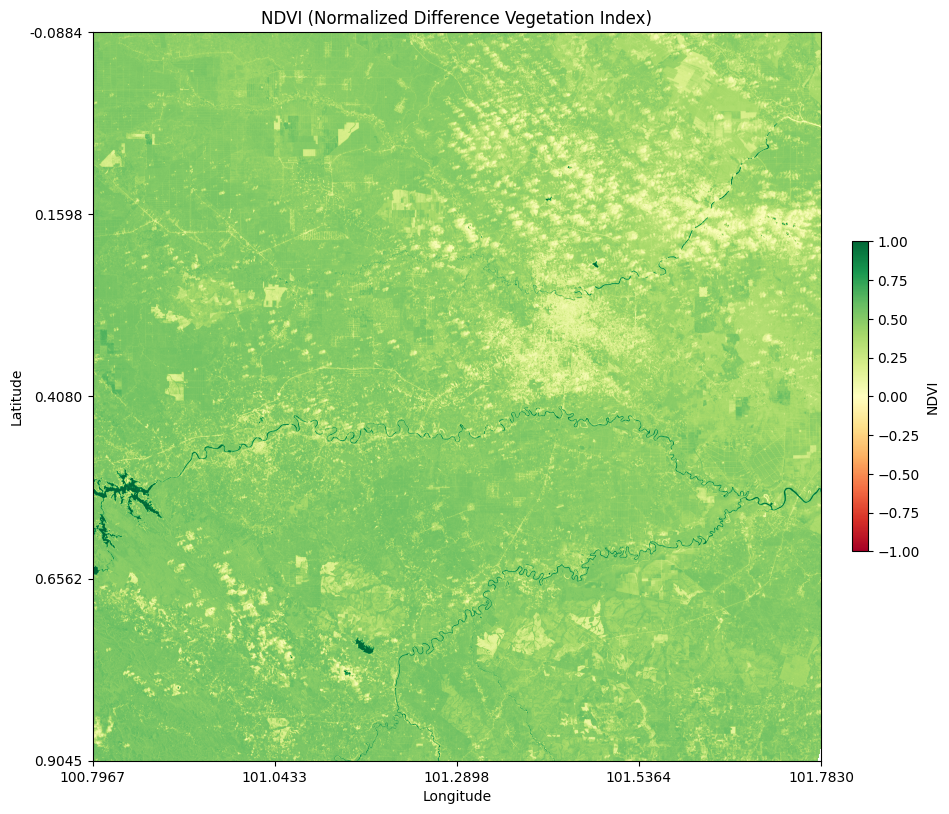

In [24]:
# Plot the NDVI
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the NDVI image with values between -1 and 1
cax = ax.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)  # Set limits for NDVI range (-1 to 1)

ax.set_xlim(0, ndvi.shape[1])
ax.set_ylim(ndvi.shape[0], 0)  # Invert y-axis for image coordinates

# Add a colorbar with dynamic size based on the figure's height
cbar = plt.colorbar(cax, ax=ax, fraction=0.02, pad=0.04)
cbar.set_label('NDVI')

# Set coordinate grid and labels
lon_ticks = np.linspace(lon_min, lon_max, 5)
lat_ticks = np.linspace(lat_min, lat_max, 5)

ax.xaxis.set_major_locator(mticker.FixedLocator(
    np.linspace(0, ndvi.shape[1], len(lon_ticks))))
ax.xaxis.set_major_formatter(mticker.FixedFormatter([f"{lon:.4f}" for lon in lon_ticks]))

ax.yaxis.set_major_locator(mticker.FixedLocator(
    np.linspace(0, ndvi.shape[0], len(lat_ticks))))
ax.yaxis.set_major_formatter(mticker.FixedFormatter([f"{lat:.4f}" for lat in lat_ticks]))

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.title("NDVI (Normalized Difference Vegetation Index)")
plt.show()

In [28]:
# Save NDVI as GeoTIFF adapted from NDVI AOI

# Output file path
output_ndvi_file = "ndvi_full2.tif"

# Use metadata from one of the original bands for georeferencing
with rasterio.open(band_assets["B04"]) as src:
    # Copy metadata and adjust for NDVI
    metadata = src.meta.copy()
    metadata.update({
        "driver": "GTiff",
        "dtype": "float32",  # NDVI values are floats between -1 and 1
        "count": 1,          # Single-band data
        "width": ndvi.shape[1],
        "height": ndvi.shape[0],
        "transform": src.window_transform(aoi_window),  # Use the window transform
        "crs": src.crs      # CRS stays the same as the source data
    })

    # Write the NDVI array to GeoTIFF
    with rasterio.open(output_ndvi_file, "w", **metadata) as dst:
        dst.write(ndvi, 1)  # Write NDVI to the first band

print(f"NDVI saved as {output_ndvi_file}")

NDVI saved as ndvi_full2.tif


### Calculate NDVI on AOI

In [25]:
# Extract the Red and NIR bands for NDVI calculation
with rasterio.open(band_assets["B08"]) as nir_src, \
     rasterio.open(band_assets["B04"]) as red_src:

    # Read the data (assuming same AOI bounds for simplicity)
    nir_aoi = nir_src.read(1, window=aoi_window)
    red_aoi = red_src.read(1, window=aoi_window)

    # Calculate NDVI (NIR - Red) / (NIR + Red), avoiding division by zero
    ndvi_aoi = (nir_aoi - red_aoi) / np.where((nir_aoi + red_aoi) == 0, np.nan, (nir_aoi + red_aoi))

    # Set NDVI values within range [-1, 1] - already in this range, just ensuring.
    np.clip(ndvi_aoi, -1, 1, out=ndvi_aoi)

    # Get bounds for the cropped image in EPSG:4326
    ndvi_aoi_bounds = red_src.window_bounds(aoi_window)

    # Transform bounds to EPSG:4326
    lon_min, lat_min, lon_max, lat_max = warp.transform_bounds(red_src.crs, "epsg:4326", *ndvi_aoi_bounds)

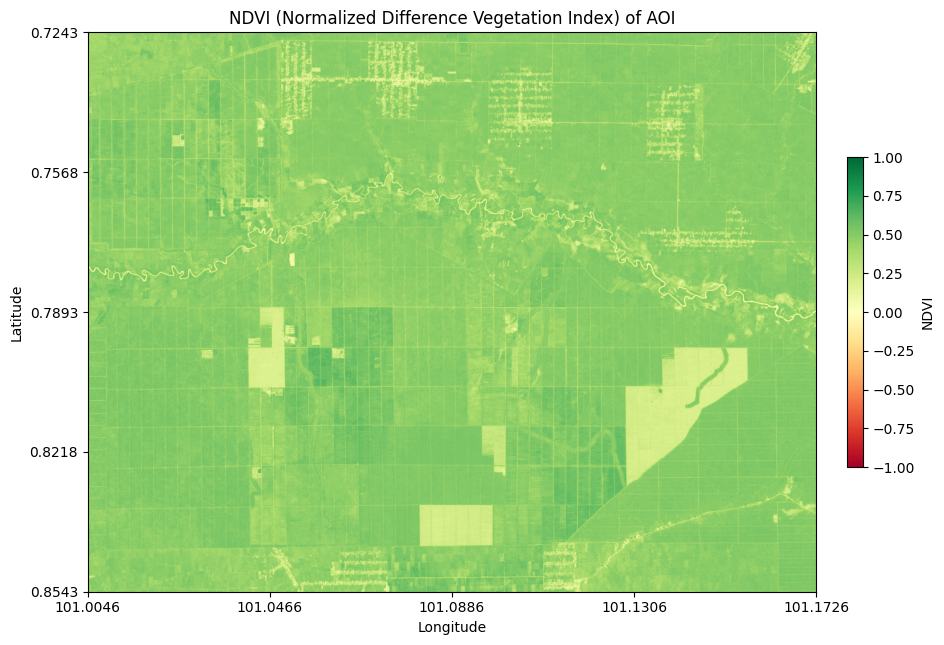

In [26]:
# Plot the NDVI on AOI
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the NDVI image with values between -1 and 1
cax = ax.imshow(ndvi_aoi, cmap='RdYlGn', vmin=-1, vmax=1)  # Set limits for NDVI range (-1 to 1)

ax.set_xlim(0, ndvi_aoi.shape[1])
ax.set_ylim(ndvi_aoi.shape[0], 0)  # Invert y-axis for image coordinates

# Add a colorbar with dynamic size based on the figure's height
cbar = plt.colorbar(cax, ax=ax, fraction=0.02, pad=0.04)
cbar.set_label('NDVI')

# Set coordinate grid and labels
lon_ticks = np.linspace(lon_min, lon_max, 5)
lat_ticks = np.linspace(lat_min, lat_max, 5)

ax.xaxis.set_major_locator(mticker.FixedLocator(
    np.linspace(0, ndvi_aoi.shape[1], len(lon_ticks))))
ax.xaxis.set_major_formatter(mticker.FixedFormatter([f"{lon:.4f}" for lon in lon_ticks]))

ax.yaxis.set_major_locator(mticker.FixedLocator(
    np.linspace(0, ndvi_aoi.shape[0], len(lat_ticks))))
ax.yaxis.set_major_formatter(mticker.FixedFormatter([f"{lat:.4f}" for lat in lat_ticks]))

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.title("NDVI (Normalized Difference Vegetation Index) of AOI")
plt.show()

In [27]:
# Save NDVI as GeoTIFF

# Output file path
output_ndvi_aoi_file = "ndvi_aoi.tif"

# Use metadata from one of the original bands for georeferencing
with rasterio.open(band_assets["B04"]) as src:
    # Copy metadata and adjust for NDVI
    metadata = src.meta.copy()
    metadata.update({
        "driver": "GTiff",
        "dtype": "float32",  # NDVI values are floats between -1 and 1
        "count": 1,          # Single-band data
        "width": ndvi_aoi.shape[1],
        "height": ndvi_aoi.shape[0],
        "transform": src.window_transform(aoi_window),  # Use the window transform
        "crs": src.crs      # CRS stays the same as the source data
    })

    # Write the NDVI array to GeoTIFF
    with rasterio.open(output_ndvi_aoi_file, "w", **metadata) as dst:
        dst.write(ndvi_aoi, 1)  # Write NDVI to the first band

print(f"NDVI saved as {output_ndvi_aoi_file}")

NDVI saved as ndvi_aoi.tif


## Image Classificication

### NDVI to Health Indication by Lillesand, 2015

In [ ]:
"""
# Classify NDVI values into health categories based on thresholds
def classify_oil_palm_health(ndvi):
    """
    Classify oil palm health based on NDVI value ranges.
    Input: NDVI array.
    Output: Classified health condition array (integer labels).
    """
    # Initialize a classification array (default: 0 = Dead Plants)
    health_class = np.zeros_like(ndvi, dtype=int)

    # Apply classifications based on NDVI thresholds
    health_class[(ndvi > -1) & (ndvi <= 0)] = 1  # Dead Plants
    health_class[(ndvi > 0) & (ndvi <= 0.33)] = 2  # Unhealthy Plants
    health_class[(ndvi > 0.33) & (ndvi <= 0.66)] = 3  # Moderately Healthy Plants
    health_class[(ndvi > 0.66) & (ndvi <= 1)] = 4  # Very Healthy Plants

    return health_class

# Classify oil_palm health
oil_palm_health = classify_oil_palm_health(ndvi)

# Oil palm health array:
# 0 = Background (optional, if no oil palm)
# 1 = Dead Plants
# 2 = Unhealthy Plants
# 3 = Moderately Healthy Plants
# 4 = Very Healthy Plants
"""

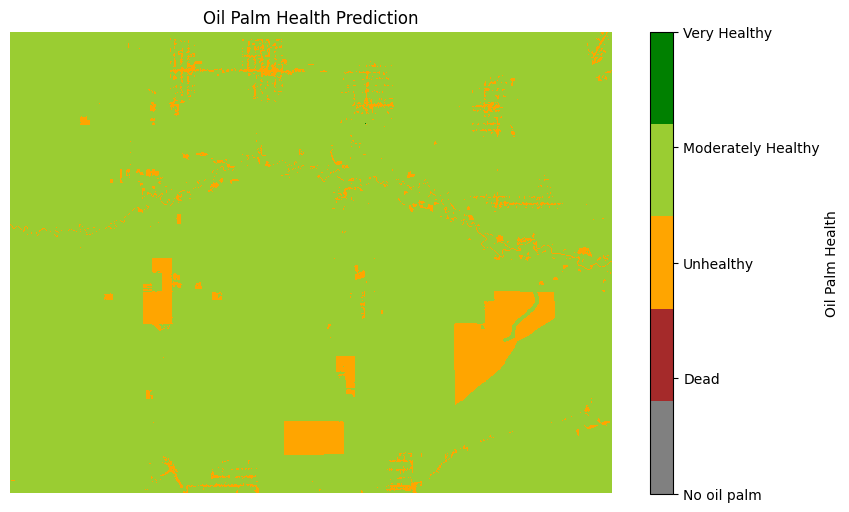

In [ ]:
"""
# Visualization

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define a colormap for the categories
cmap = ListedColormap(["gray", "brown", "orange", "yellowgreen", "green"])
boundaries = [0, 1, 2, 3, 4, 5]
norm = plt.Normalize(vmin=0, vmax=4)

# Create the figure and plot
plt.figure(figsize=(10, 6))
plt.imshow(oil_palm_health, cmap=cmap, norm=norm)

# Create the colorbar with adjusted ticks
cbar = plt.colorbar(ticks=[0, 1, 2, 3, 4])  # Adjust ticks to match actual boundaries
cbar.ax.set_yticklabels([
    "No oil palm",
    "Dead",
    "Unhealthy",
    "Moderately Healthy",
    "Very Healthy"
])  # Provide labels for all classifications
cbar.set_label("Oil Palm Health")

# Add title and hide axes
plt.title("Oil Palm Health Prediction")
plt.axis("off")
plt.show()
"""

### NDVI to Health Indication by Rahaldi, 2013

In [26]:
# Classify NDVI values into health categories based on thresholds
def classify_oil_palm_health(ndvi):
    """
    Classify oil palm health based on NDVI value ranges.
    Input: NDVI array.
    Output: Classified health condition array (integer labels).
    """
    # Initialize a classification array (default: 0 = Dead Plants)
    health_class = np.zeros_like(ndvi, dtype=int)

    # Apply classifications based on NDVI thresholds
    health_class[(ndvi > -1) & (ndvi <= 0)] = 1  # Dead Plants
    health_class[(ndvi > 0.1) & (ndvi <= 0.22)] = 2  # Unhealthy Plants
    health_class[(ndvi > 0.22) & (ndvi <= 0.42)] = 3  # Normal Plants
    health_class[(ndvi > 0.42) & (ndvi <= 1)] = 4  # Healthy Plants

    return health_class

# Classify oil palm health
oil_palm_health = classify_oil_palm_health(ndvi)

# Oil palm health array:
# 0 = Background (optional, if no oil palm)
# 1 = Dead Plants
# 2 = Unhealthy Plants
# 3 = Moderately Healthy Plants
# 4 = Very Healthy Plants

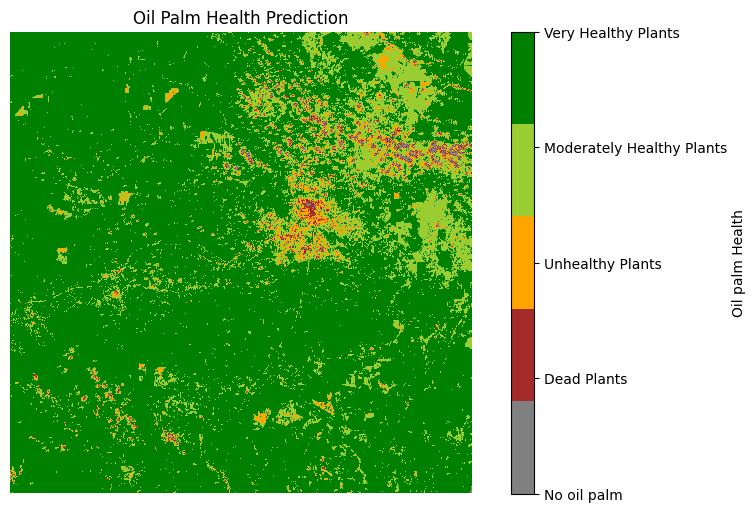

In [27]:
# Visualization

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define a colormap for the categories
cmap = ListedColormap(["gray", "brown", "orange", "yellowgreen", "green"])
boundaries = [0, 1, 2, 3, 4, 5]
norm = plt.Normalize(vmin=0, vmax=4)

# Create the figure and plot
plt.figure(figsize=(10, 6))
plt.imshow(oil_palm_health, cmap=cmap, norm=norm)

# Create the colorbar with adjusted ticks
cbar = plt.colorbar(ticks=[0, 1, 2, 3, 4])  # Adjust ticks to match actual boundaries
cbar.ax.set_yticklabels([
    "No oil palm",
    "Dead Plants",
    "Unhealthy Plants",
    "Moderately Healthy Plants",
    "Very Healthy Plants"
])  # Provide labels for all classifications
cbar.set_label("Oil palm Health")

# Add title and hide axes
plt.title("Oil Palm Health Prediction")
plt.axis("off")
plt.show()

In [29]:
# Save oil_palm_health as GeoTIFF
# Save the classified oil palm health array as GeoTIFF
output_file = "oil_palm_health_prediction_full.tif"

# Use metadata from one of the original bands for georeferencing
with rasterio.open(band_assets["B04"]) as src:  # Adjust this to an existing band
    # Retrieve metadata and modify it for the new dataset
    metadata = src.meta.copy()
    metadata.update({
        "driver": "GTiff",
        "dtype": "int32",  # Data type suitable for classifications
        "count": 1,        # Single band for classified data
        #"compress": "lzw",  # Optional compression
        "width": oil_palm_health.shape[1],
        "height": oil_palm_health.shape[0],
        "transform": src.window_transform(aoi_window),  # Use the window transform
        "crs": src.crs,  # WGS84 Latitude/Longitude coordinate system
    })

    # Write the classified data to a new file
    with rasterio.open(output_file, "w", **metadata) as dst:
        dst.write(oil_palm_health, 1)

print(f"Oil palm health classification saved as {output_file}")

Oil palm health classification saved as oil_palm_health_prediction_full.tif


# Phase 2: Dataset Preparation

## Image Patching

## Image Sampling

## Image Labelling